## Time Series Prediction Using Autoregressive Tree

# Table of Contents
>[1. Autoregressive trees](#section1)
<br>[2. Learning Framework](#section2)
<br>[3. Preprocessing and Loading Data and Libraries](#section3)
<br>[4. Autoregressive Tree Class](#section4)
<br>[5. Model Training](#section5)
<br>[6. Evaluation](#section6)
<br>[7. Results](#section7)
<br>[Bonus Section](#section8)
<br>[References](#section9)

# Autoregressive Tree Models for Time-Series Analysis
Current demo is based on a paper with the same name. The main purpose of C. Meek et al. was to identify models for continuous-valued univariate time-series prediction, which are useful for data mining due to efficacy of learning from the data, supporting accurate predictions and having straightforward interpretation. Generally speaking, ART models are generalization of the AR models, as we compute several AR models for our data, using Decision Tree structure.
<br><br>Roughly speaking, for constructing ART models, first standard windowing process is applied to time-series, for producing a set of data, being suitable for regression. Then, transformed data is used for training a Decision Tree based on the prediction of the corresponding target value. In other words, at each of the Decision Tree leaves, there exists a piece-wise auto-regression model. The novelty of this work with respect to previous attempts, is the usage of a Bayesian approach for model selection, and outperforming results, which are still easy to interpret for data mining purposes.
<a id='section1'></a>
## 1. Autoregressive Trees
In this work, researchers restricted to consideration of the time-series which are probabilistic, stationary and p-order Markov:
<br><br>\begin{equation*} p(y_t|y_1,...,y_{t-1},\theta) = f(y_t|y_{t-p},...,y_{t-1},\theta), p < t \leq T \end{equation*}
<br>Stationarity means dependence of $y_t$ on previous variables does not change over time, and $p$-order Markov means, given previous $p$ observations, $y_t$ is independent of the remaining previous observation
### 1.1 ART Models

ART($p$) model is an ART model, in which each leaf of the tree contains AR($p$), and split values are chosen among the previous $p$ variables. Thus, these models can be easily compared to AR models.
If we have $L$ leaves then we have set of $L$ different $\theta$s. Each theta is set of parameter regarding to AR model.
<br><br>\begin{equation*} f(y_t|y_{t-p},...,y_{t-1},\theta) = N(m + \sum_{j=1}^{p} b_j y_{t-j}, \sigma ^2) \end{equation*}
<br>Where $\theta = (m, b_1,...,b_p, \sigma ^2)$ are model parameters, and $N(\mu , \sigma ^2)$ is a normal distribution with mean $\mu$ and variance $\sigma ^2$
<br><br>An ART($p$) model is defined as following:
<br><br>\begin{equation*} f(y_t|y_{t-p},...,y_{t-1},\theta) = \prod_{i=1}^{L} f_i(y_t|y_{t-p},...,y_{t-1},\theta _i)^{\phi _i} = \prod_{i=1}^{L} N(m_i + \sum_{j=1}^{p} b_{ij} y_{t-j}, \sigma _i^2) \end{equation*}
<br>Where $L$ is number of leaves, $\theta = (\theta _1,...,\theta _L)$ and, $\theta _i = (m_i, b_{i1},...,b_{ip}, \sigma _i^2)$ are model parameters for linear regression at each leaf, $l_i$.
<br><br>As it is mentioned earlier, ART($p$) models are generalization of the AR models, because an ART($p$) model with only one leaf is just a AR($p$) model. Here is an example of ART model [1].
![ART model example](img/ART_model.png)
<a id='section2'></a>
## 2. Learning Framework
First, they considered a general Bayesian approach for learning. In this approach there will be alternative model structures $s_1,...,s_S$ with their corresponding parameters $\theta _{s_1},...,\theta _{s_S}$. Also, the uncertainty about the structures and their parameter can be expressed by placing distributions on them: $p(s)$ and $p(\theta _s|s)$. Then, Bayes rule alongside the data, $d$, is used in order to infer posterior distributions over these quantities: $p(s|d)$ and $p(\theta _s|d,s)$. Using Bayesian model selection method, a structure "$s$" with highest posterior probability $p(s|d)$ is chosen. Also, predictions are made by $p(\theta _s|d,s)$, for that $s$.
Using Bayes rule, posterior probability of model structure is given by:
<br><br>\begin{equation*} p(s|d) = \frac{p(s)p(d|s)}{p(d)} \end{equation*}
<br>As $p(d)$ constant, finding the nominator of the ratio is enough for choosing the best structure. $p(s)p(d|s)$ refered as Bayesian score for the model. considering Bayesian score, $p(s)$ is structure prior, and $p(d|s)$ is marginal likelihood.
<br><br>Now, Bayesian approach can be used for learning a stationary, $p$-order Markov time-series, based on what is mentioned so far, in order to write likelihood of the data.
<br><br>\begin{equation*} p(y_{p+1},...,y_{T}|y_1,...,y_p,\theta,s) = \prod_{t=p+1}^{T} f(y_t|y_{t-p},...,y_{t-1},\theta,s) \end{equation*}
<br>Note that first $p$ observations are removed due to the fact that $p$-order Markov model can not predict these observations.
<br><br>For a single sequence $y = (Y_1,...,Y_T)$, windowing transformation to a set of cases $x^1,...,x^T$ is given by:
<br><br>\begin{equation*} x^i = (x_1^i,...,x_{p+1}^i),\:\:1<i<T-p,\:\:where\:\:x_j^i=y_{i+j-1} \end{equation*}
<br>Given the windowing transformation we will have:
<br><br>\begin{equation*} p(y_{p+1},...,y_{T}|y_1,...,y_p,\theta,s) = \prod_{t=p+1}^{T} f(x_{p+1}^t|x_{1}^t,...,x_{p}^t, \theta ,s) \end{equation*}
<br>The likelihood is the likelihood for an ordinary regression model for traget value $X_{p+1}$ and regressor values $X_1,...,X_p$.
### 2.1 The Bayesian score for an ART model
Let's consider an ART($p$) model. From the computational and efficacy perspective, it's desirable that model score is calculated in closed form. As a result we make the following assumptions. First, model structure a priori likelihood is given by $p(s) = \kappa ^{|\theta |}$, in which $0<\kappa \leq 1$ and $|\theta |$ is number of parameters. In this experiment $\kappa $ is set to $0.1$.
<br><br>Second, all parameters in different leaves are independent from each other. Consequently, using these two assumptions we can write:
<br><br>\begin{equation*} score(s) = \prod_{i=1}^{L} LeafScore(l_i) \end{equation*}
<br>Where
<br><br>\begin{equation*} LeafScore(l_i) = \kappa ^{p+2} \int \prod_{x^t\:at\:\:l_i} f_i(x_{p+1}^t|x_{1}^t,...,x_{p}^t, \theta _i,s) p(\theta _i,s) d\theta _i \end{equation*}
<br>Where it consist of $(1)$ the priori probability of the leaf of the structure, and $(2)$ the marginal likelihood of the data falling into that leaf.
### 2.2 Searching for the ART model structure and Training a Decision Tree
Regarding the fact that a Decision Tree algorithm is used for building an ART model, an algorithm for training Decision Tree is required. As a result, using greedy search algorithm, we need to apply $slpit-leaf$ operator to all leaves in order to find split variables and their corresponding split values.
<br><br>First of all, in order to find split variables, we need to loop over all regressor variable, $X_1,...,X_p$. Then for finding desired split value, we restrict our attention on seven values, which are boundaries of the eight contiguous regions of a normal distribution estimated from the the data restricted in each leaf. For justification, readers can refer to this study. Using normal distribution assumption for the data left in each leaf, these seven points can be calculated from:
<br><br>\begin{equation*} c_i = \mu _L + \sigma _L \Phi ^{-1} (\frac{i}{k + 1}) \end{equation*}
<br>Where $\Phi ^{-1}$ is cumulative distribution function of the standard Gaussian, $\mu _L$ and $\sigma _L$ are sample mean and sample standard deviation, respectively. In this experiment $k$ is set to seven, and $i$ goes from $1$ to $7$.
<br><br>The tree is grown by applying $split-leaf$ operator iteratively to all leaf to check if there exists any outcome, which increase the total score of a structure.
### 2.3 Forecasting with ART models
In one-step forecasting, we want to predict target value $y_{T+1}$, based on predictor values $y_1,...,y_T$. In this case, posterior distribution of the variable $Y_{T+1}$ is a function of a single leaf. The normal distribution $f_i(y_t|y_{t-p},...,y_{t-1})$ is used to evaluate the $\theta _i$ that is most likely given the data (the maximum a posteriori or MAP value):
<br><br>\begin{equation*} \widetilde{\theta} _i = \prod_{x^t\:at\:\:l_i} f_i(x_{p+1}^t|x_{1}^t,...,x_{p}^t, \theta _i,s) p(\theta _i,s) \end{equation*}
<br>Next, the expressions for $\widetilde{\theta} _i$ and and $LeafScore(l_i)$ is given in the Section 4.

<a id='section3'></a>
## 3. Preprocessing and Loading Data and Libraries
In this stage we decide either normalize or remove seasonality and trend from the data.
### 3.1 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import det, inv
from scipy.special import gamma
from math import pi, ceil
from scipy.special import erfinv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from random import randint
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.filterwarnings("ignore")

### 3.2 Loading Dataset
The data is from [M3 Competition](http://forecasters.org/data/m3comp/m3comp.htm). The whole dataset contains 3003 time series, containing information on the series ID number, number of data points, type of time series, the starting date of the data and the short description for time series. The time series are distributed as follows:
</h2><table class='table table-striped'> <thead> <tr> <th>Interval</th> <th>Micro</th> <th>Industry</th> <th>Macro</th> <th>Finance</th> <th>Demog</th> <th>Other</th> <th>Total</th> </tr> </thead> <tbody> <tr> <th scope='row'>Yearly</th> <td>146</td> <td>102</td> <td>83</td> <td>58</td> <td>245</td> <td>11</td> <td>645</td> </tr> <tr> <th scope='row'>Quarterly</th> <td>204</td> <td>83</td> <td>336</td> <td>76</td> <td>57</td> <td>0</td> <td>756</td> </tr> <tr> <th scope='row'>Monthly</th> <td>474</td> <td>334</td> <td>312</td> <td>145</td> <td>111</td> <td>52</td> <td>1428</td> </tr> <tr> <th scope='row'>Other</th> <td>4</td> <td>0</td> <td>0</td> <td>29</td> <td>0</td> <td>141</td> <td>174</td> </tr> <th scope='row'>Total</th> <td>828</td> <td>519</td> <td>731</td> <td>308</td> <td>413</td> <td>204</td> <td>3003</td> </tbody> </table>

In [2]:
xls = pd.ExcelFile('M3C.xls')
df1 = pd.read_excel(xls, 'M3Year')
df2 = pd.read_excel(xls, 'M3Quart')
df3 = pd.read_excel(xls, 'M3Month')
df4 = pd.read_excel(xls, 'M3Other')

### 3.3 Normalization
In this method we use z-score normalization:
\begin{equation*} x_{std} = \frac{x - \bar{x}}{std(x)} \end{equation*} 
### 3.4 Seasonality and Trend
Although stationarity is an assumption being made for most of the time series models, almost none of the real-life time series examples are stationary. As a result, statisticians came up with methods to make time series stationary. We should note that making a given time series completely stationary is not possible. In other words, these methods make time series as stationary as possible.
There are two main reasons behind time series non-stationarity:
#### 3.4.1 Trend
Which is defined as a varying mean over time.
#### 3.4.2 Seasonality
which are variations at a specific time frames.
<br><br>The main idea is to first remove estimate the stationary part of the signal. Then, after applying time series forecasting algorithms, we should convert the predicted values into the original scale, by applying seasonality and trend back.
<br> The main method for elimination of trend and seasonality:
#### 3.4.3 Differencing
Which is taking difference with a particular time lag
### 3.5 Choosing Time-series
From the time-series discussed earlier, monthly datasets, which are larger than 130 time stamps are chosen for this study. The total number of time-series that fulfill this criterion are 799.

In [3]:
def preprocessing(data, method):
    ts_train = []
    ts_valid = []
    ts_test = []
    ts_param = []
    flag_n = False
    flag_diff = False
    flag_dec = False
    if method is 'normalization':
        flag_n = True
    elif method is 'differencing':
        flag_diff = True
            
    for i in range(data.shape[0]):

        temp = list(data.iloc[i][6:].dropna())

        if len(temp) > 130:
            
            cut_off_1 = ceil(len(temp)*0.7)
            cut_off_2 = ceil(len(temp)*0.9)

            temp_train = temp[:cut_off_1]
            temp_val = temp[cut_off_1:cut_off_2]
            temp_test = temp[cut_off_2:]

            if flag_n is True:
                ts_param.append([np.mean(temp_train), np.std(temp_train), np.mean(temp_val), 
                np.std(temp_val), np.mean(temp_test), np.std(temp_test)])
                
                temp_train = (temp_train - np.mean(temp_train)) / np.std(temp_train)
                ts_train.append(temp_train)
                

                temp_val = (temp_val - np.mean(temp_val)) / np.std(temp_val)
                ts_valid.append(temp_val)

                temp_test = (temp_test - np.mean(temp_test)) / np.std(temp_test)
                ts_test.append(temp_test)
                

            elif flag_diff is True:

                temp_train = pd.Series(temp_train)
                temp_train_log_diff = temp_train - temp_train.shift()
                temp_train_log_diff[0] = temp_train[0]
                temp_train_log_diff.dropna(inplace=True)
                ts_train.append(temp_train_log_diff.values)

                temp_val = pd.Series(temp_val)
                temp_val_log_diff = temp_val - temp_val.shift()
                temp_val_log_diff[0] = temp_val[0]
                temp_val_log_diff.dropna(inplace=True)
                ts_valid.append(temp_val_log_diff.values)

                temp_test = pd.Series(temp_test)
                temp_test_log_diff = temp_test - temp_test.shift()
                temp_test_log_diff[0] = temp_test[0]
                temp_test_log_diff.dropna(inplace=True)
                ts_test.append(temp_test_log_diff.values)
                
    return ts_train, ts_valid, ts_test, ts_param

<a id='section4'></a>
## 4. Autoregressive Tree Class
The relationship between $X_{p+1}$ and $X_1,...,X_p$ is the linear regression
<br><br>\begin{equation*} p(x_{p+1}^t|x_{1}^t,...,x_{p}^t, \theta ,s) = N(m + \sum_{j=1}^{p} b_j y_{t-j}, \sigma ^2),\:\:t=1,...,N \end{equation*}
<br>Where
<br><br>\begin{equation*} m = \mu _{p+1} - \sum_{i=1}^{p} b_i \mu_i ,\:\:b_j = \sum_{i=1}^{p} (W^{-1})_{p+1,i}\: (((W^{-1})^{p \times p})^{-1})_{i,j},\:\:\sigma ^2 = \frac{1}{W_{p+1,p+1}} \end{equation*}
<br>The MAP parameters that maximize $p(d|\theta ,s)$ is given by
<br><br>\begin{equation*} \widetilde{\mu} = \frac{\alpha_{\mu} \mu_0 + N \mu_N}{\alpha_{\mu} + N},\:\:\widetilde{W}^{-1} = \frac{1}{\alpha_W + N - (p+1)} W_N \end{equation*}
<br>Where
<br><br>\begin{equation*} W_N = W_0 + S_N + \frac{\alpha_{\mu} N}{\alpha_{\mu} + N} (\mu_0 - \bar{\mu_N})(\mu_0 - \bar{\mu_N})' \end{equation*}
<br>The terms $\bar{\mu_N}$ and $S_N$ are mean sample and scatter matrix, respectively
<br><br>\begin{equation*} \bar{\mu_N} = \frac{1}{N} \sum_{t=1}^N x^t,\:\: S_N = \sum_{t=1}^N (x^t - \bar{\mu_N})(x^t - \bar{\mu_N})' \end{equation*}
<br>Finally, the (conditional) marginal likelihood is given by
<br><br>\begin{equation*} \int \prod_{t=1}{N} p(x_{p+1}^t|x_{1}^t,...,x_{p}^t, \theta _i,s) p(\theta _i,s) d\theta _i = \frac{p(d|s)}{p(d^-|s)} \end{equation*}
<br>Where
<br><br>\begin{equation*} p(d|s) = \pi^{- \frac{(p+1)N}{2}} (\frac{\alpha _\mu}{\alpha _\mu + N})^2 \frac{c(p+1, \alpha _W + N)}{c(p+1, \alpha _W)} |W_0|^{\frac{\alpha _W}{2}} |W_N|^{\frac{\alpha _W + N}{2}} \end{equation*}
<br>Where
<br><br>\begin{equation*} c(l, \alpha) = \prod_{i=1}^l \Gamma (\frac{\alpha + 1 - i}{2}) \end{equation*}
<br>If we let Thus, if we let $d^-$ be the data $d$ restricted to the variables X_1,...,X_p, then the marginal likelihood p(d^{-}|s) is given by the p-dimensional version of Equation above, with $\mu _0$, $W_0$, and $\alpha _W$, replaced by $\mu _0 ^-$, $W_0^-$ and $\alpha _W - 1$, respectively.
<br><br>In our experiment, we use $\mu _0 = 0$, $W_0 = I$, $\alpha _ \mu = 1$ and $\alpha _W = p + 2$ applied to the data.

In the following code, a Decision Tree has been implemented inspired by [Jason Brownlee](https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/) and fully customized to our problem.

In [4]:
import numpy as np
from numpy.linalg import det, inv
from scipy.special import gamma
from math import pi
from scipy.special import erfinv

class AutoregressiveTree:
    
    def __init__(self, p, u0=0, alpha_u=1):
        
        erf_temp = np.zeros([7,1])
        for i in range(1,8):
            erf_temp[i-1] = erfinv((i/4) - 1)
        
        self._erf = erf_temp
        self._p = p
        self._alpha_W = p + 2
        self._u0 = u0
        self._alpha_u = alpha_u
    
    def sample_mean(self, data):
        return sum(data) / len(data)
    
    def scatter_matrix(self, data, uN_):
        temp = data - uN_
        SN = 0
        for row in temp:
            row = row[:, np.newaxis]
            SN += row * row.T
        
        return SN
    
    def WN_func(self, uN_, SN, W0, N):
        temp = self._u0 - uN_
        temp = temp[:, np.newaxis]
        WN = W0 + SN + ((self._alpha_u * N) / (self._alpha_u + N)) * np.dot(temp, temp.T)
        return WN
    
    def WN_d_func(self, u0_, uN_d_, SN_d_, W0_, N_):
        temp = u0_ - uN_d_
        temp = temp[:, np.newaxis]
        WN_ = W0_ + SN_d_ + ((self._alpha_u * N_) / (self._alpha_u + N_)) * np.dot(temp, temp.T)
        return WN_
    
    def MAP_param(self, N, uN_, WN):
        ut = ((self._alpha_u * self._u0) + (N * uN_)) / (self._alpha_u + N)
        Wt_inv = (1 / (self._alpha_W + N - (self._p + 1))) * WN
        return ut, Wt_inv
    
    def param(self, data):
        N = len(data)
        uN_ = self.sample_mean(data)
        SN = self.scatter_matrix(data, uN_)
        W0 = np.identity(SN.shape[0])
        WN = self.WN_func(uN_, SN, W0, N)
        ut, Wt_inv = self.MAP_param(N, uN_, WN)
        W = inv(Wt_inv)
        var = 1 / W[-1, -1]
        Wpp = inv(Wt_inv[:-1, :-1])
        b = np.zeros([self._p, 1])
        for j in range(len(b)):
            for i in range(self._p):
                b[j] += Wt_inv[-1, i] * Wpp[i, j]
        
        m = ut[-1]
        for i in range(self._p):
            m += b[i] * ut[i]
        
        return var, b, m[0]
    
    def c_func(self, l, alpha):
        c = 1
        #   for loop goes from 1 to l
        for i in range(1, l + 1):
            c *= gamma((alpha + 1 - i) / 2)
        
        return c
    
    def pds_func(self, N, W0, WN):
        pds = (pi**(-((self._p + 1) * N) / 2)) + \
        ((self._alpha_u / (self._alpha_u + N))**((self._p + 1) / 2)) + \
        (self.c_func(self._p + 1, self._alpha_W + N) / self.c_func(self._p + 1, self._alpha_W)) * (det(W0)**(self._alpha_W / 2))*(det(WN)**(-(self._alpha_W + N) / 2))
        return pds
    
    def pd_s_func(self, u0_, N_, W0_, WN_):
        pds = (pi**(-((self._p + 1) * N_) / 2)) + \
        ((self._alpha_u / (self._alpha_u + N_))**((self._p + 1) / 2)) + \
        (self.c_func(self._p + 1, self._alpha_W - 1 + N_) / self.c_func(self._p + 1, self._alpha_W - 1)) * (det(W0_)**((self._alpha_W - 1) / 2))*(det(WN_)**(-(self._alpha_W - 1 + N_) / 2))
        return pds
    
    def LeafScore(self, data):
        N = len(data)
        uN_ = self.sample_mean(data)
        SN = self.scatter_matrix(data, uN_)
        W0 = np.identity(SN.shape[0])
        WN = self.WN_func(uN_, SN, W0, N)
        ut, Wt_inv = self.MAP_param(N, uN_, WN)
        pds = self.pds_func(N, W0, WN)
        data_ = []
        for x in data:
            data_.append(x[:-1])
        
        N_ = len(data_)
        uN_d_ = self.sample_mean(data_)
        SN_d_ = self.scatter_matrix(data_, uN_d_)
        u0_ = ut[:-1]
        W0_ = inv(inv(W0)[:-1, :-1])
        WN_d_ = self.WN_d_func(u0_, uN_d_, SN_d_, W0_, N_)
        pds_ = self.pd_s_func(u0_, N_, W0_, WN_d_)
        return pds / pds_
    
    def test_split(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return left, right
    
    def get_split(self, dataset):
        b_index, b_value, b_groups = 999, 999, None
        b_score = self.LeafScore(dataset)
        avg = np.mean(dataset, axis=0)[:-1]
        sigma = np.std(dataset, axis=0)[:-1]
        for index in range(len(avg)):
            for i in range(len(self._erf)):
                value = avg[index] + sigma[index] * self._erf[i]
                groups = self.test_split(index, value, dataset)
                new_score = 1
                for group in groups:
                    if len(group) != 0:
                        new_score *= self.LeafScore(group)
            
                        if new_score > b_score:
                            b_index, b_value, b_score, b_groups = index, value, new_score, groups
        
        return {'index':b_index, 'value':b_value, 'groups':b_groups}
    
    def to_terminal(self, group):
        outcomes = self.param(group)
        return outcomes
    
    def split(self, node, max_depth, min_size, depth):
        left, right = node['groups']
        del(node['groups'])
        if not left or not right:
            node['left'] = node['right'] = self.to_terminal(left + right)
            return
        
        if depth >= max_depth:
            node['left'], node['right'] = self.to_terminal(left), self.to_terminal(right)
            return
        
        if len(left) <= min_size:
            node['left'] = self.to_terminal(left)
        else:
            node['left'] = self.get_split(left)
            if node['left']['groups'] is None:
                node['left'] = self.to_terminal(left)
            else:
                self.split(node['left'], max_depth, min_size, depth+1)
        
        if len(right) <= min_size:
            node['right'] = self.to_terminal(right)
        else:
            node['right'] = self.get_split(right)
            if node['right']['groups'] is None:
                node['right'] = self.to_terminal(right)
            else:
                self.split(node['right'], max_depth, min_size, depth+1)
    
    def build_tree(self, train, max_depth, min_size):
        root = self.get_split(train)
        if root['groups'] is None:
            root['root'] = self.to_terminal(train)
            root['index'] = None
            root['value'] = None
            del(root['groups'])
        else:
            self.split(root, max_depth, min_size, 1)
        
        return root
    
    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            if node['value'] is None:
                print(node)
                return
            print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
            self.print_tree(node['left'], depth+1)
            self.print_tree(node['right'], depth+1)
    
        else:
            print('%s[%s]' % ((depth*' ', node)))
    
    def predict(self, node, row):
        if 'root' in node:
            return node['root']
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self.predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict(node['right'], row)
            else:
                return node['right']

<a id='section5'></a>
## 5. Model Training
In this function, both ART and AR models are trained for a given time series index, up to a model order parameter, $p$. This method called each time we want build models for a specific time series. Eventually, outcome of every trained model is evaluated at the last step of this function.

In [5]:
def time_series_pred(data, time_series_index, pred_method, max_p, preprocessing_method):
    ts_train, ts_valid, ts_test, ts_param = preprocessing(data, method=preprocessing_method)

    p_set = [i for i in range(1,max_p+1)]
    mse_our_model = []
    mse_arima = []
    valid_prediction_list = []
    valid_prediction_list_cumsum = []
    #   Example
    idx = time_series_index
    d_val = ts_valid[idx][1:]
    d_test = ts_test[idx]
    tree_list = []
    for p in p_set:
        train = []
        for s in ts_train:
            temp = []
            for i in range(len(s) - (p + 1)):
                temp.append(s[i:i + p + 1])

            train.append(temp)
        d = train[idx]
        ART = AutoregressiveTree(p)
        tree = ART.build_tree(d, 100, 3)
        tree_list.append(tree)
        valid_prediction = []
        valid_window = d[-1][1:]
        moving_val = ts_train[idx]
        if pred_method is 'ART':
            for i in range(len(d_val)):
                parameters = ART.predict(tree, valid_window)
                prediction_temp = np.dot(valid_window[:,np.newaxis].T,parameters[1]) + parameters[2]
                valid_prediction.append(prediction_temp[0][0])
                valid_window = np.append(valid_window, d_val[i])
                valid_window = valid_window[1:]
            valid_prediction_list.append(valid_prediction)
            valid_prediction = pd.Series(valid_prediction, copy=True)
            if preprocessing_method is 'differencing':
                train_s = pd.Series(ts_train[idx], copy=True).cumsum()
                last_value_train= pd.Series.tolist(train_s)[-1]
                valid_prediction_temp = [0]*(len(valid_prediction)+1)
                valid_prediction_temp[1:] = valid_prediction
                valid_prediction_temp[0] = last_value_train
                valid_prediction_temp = pd.Series(valid_prediction_temp, copy=True)
                valid_prediction_cumsum = valid_prediction_temp.cumsum()
                valid_prediction_list_cumsum.append(valid_prediction_cumsum)
            elif preprocessing_method is 'normalization':
                d_val_mean = ts_param[idx][2]
                d_val_std = ts_param[idx][3]
                valid_prediction_denorm= (valid_prediction * d_val_std) + d_val_mean
                valid_prediction_list_cumsum.append(valid_prediction_denorm)
        elif pred_method is 'AR':
            for i in range(len(d_val)):
                #           alid_window = np.append(valid_window, prediction)
                moving_val = moving_val[~np.isnan(moving_val)]
                model = ARIMA(moving_val, order=(p,1,0))
                model_fit = model.fit(disp=-1)
                prediction_temp = model_fit.forecast()
                valid_prediction.append(prediction_temp[0])
                moving_val = np.append(moving_val, d_val[i])
                d_val = pd.Series(d_val, copy=True)
            valid_prediction = pd.Series(valid_prediction, copy=True)
            valid_prediction_list.append(valid_prediction)
            if preprocessing_method is 'differencing':
                train_s = pd.Series(ts_train[idx], copy=True).cumsum()
                last_value_train= pd.Series.tolist(train_s)[-1]
                valid_prediction_temp = [0]*(len(valid_prediction)+1)
                valid_prediction_temp[1:] = valid_prediction
                valid_prediction_temp[0] = last_value_train
                valid_prediction_temp = pd.Series(valid_prediction_temp, copy=True)
                valid_prediction_cumsum = valid_prediction_temp.cumsum()
                valid_prediction_list_cumsum.append(valid_prediction_cumsum)
            elif preprocessing_method is 'normalization':
                d_val_mean = ts_param[idx][2]
                d_val_std = ts_param[idx][3]
                valid_prediction_denorm= (valid_prediction * d_val_std) + d_val_mean
                valid_prediction_list_cumsum.append(valid_prediction_denorm)

    if preprocessing_method is 'differencing':
        d_val_cumsum = ts_valid[idx].cumsum()
    elif preprocessing_method is 'normalization':
        d_val_mean = ts_param[idx][2]
        d_val_std = ts_param[idx][3]
        d_val_cumsum = (d_val * d_val_std) + d_val_mean
    else:
        d_val_cumsum = d_val
        
        
    return d_val, d_val_cumsum, valid_prediction_list, valid_prediction_list_cumsum, tree_list


<a id='section6'></a>
## 6. Evaluation
### 6.1 Hit Rate Calculation
Hit rate is a metric which corresponds to ratio of times our algorithm predicted increase or decrease of the time series per total number of predictions. In other words it measures is the trend prediction of our algorithm in comparison with AR model.

In [6]:
def hit_rate(ts_true, ts_pred):
    diff_true = np.diff(ts_true)
    diff_pred = np.diff(ts_pred)
    return np.sum(np.sign(diff_true) == np.sign(diff_pred)) / len(diff_true)

<a id='section7'></a>
## 7. Results
Finally, ten different time series are passed into the algorithm. Hit rate is averaged over all-time series, for each order $p$.
### 7.1. Model Training and Evaluation Using Normalized Data

In [7]:
max_p=7
hit_rate_ART_all_samples = []
hit_rate_AR_all_samples = []
rmse_ART_all_samples = []
rmse_AR_all_samples = []
time_series_index_list = [350, 786, 396, 276, 614, 377, 101, 124, 62, 35]
for i in range(0,10):
    time_series_index = time_series_index_list[i]
    print('Processing... time series number: ',time_series_index)
    time_series_index_list.append(time_series_index)
    Ground_truth_diff, Ground_truth, valid_prediction_diff_ART_list, valid_prediction_ART_list, tree = time_series_pred(data=df3, 
                                    time_series_index=time_series_index, pred_method='ART', max_p=max_p, preprocessing_method='normalization')
    _, _, valid_prediction_diff_AR_list, valid_prediction_AR_list, _ = time_series_pred(data=df3, 
                                    time_series_index=time_series_index, pred_method='AR', max_p=max_p, preprocessing_method='normalization')

    hit_rate_ART_list = []
    hit_rate_AR_list = []
    rmse_ART_list = []
    rmse_AR_list = []
    for i in range(max_p):
        hit_rate_ART_list.append(hit_rate(Ground_truth, valid_prediction_ART_list[i]))
        hit_rate_AR_list.append(hit_rate(Ground_truth, valid_prediction_AR_list[i]))
        rmse_ART_list.append(sqrt(mean_squared_error(Ground_truth, valid_prediction_ART_list[i])))
        rmse_AR_list.append(sqrt(mean_squared_error(Ground_truth, valid_prediction_AR_list[i])))
    hit_rate_ART_all_samples.append(hit_rate_ART_list)
    hit_rate_AR_all_samples.append(hit_rate_AR_list)
    rmse_ART_all_samples.append(rmse_ART_list)
    rmse_AR_all_samples.append(rmse_AR_list)

Processing... time series number:  350
Processing... time series number:  786
Processing... time series number:  396
Processing... time series number:  276
Processing... time series number:  614
Processing... time series number:  377
Processing... time series number:  101
Processing... time series number:  124
Processing... time series number:  62
Processing... time series number:  35


#### Example of trained ART

In [8]:
print('Sample ART model including split points, split values and AR parameters for each leaf')
ART = AutoregressiveTree(1)
ART.print_tree(tree[0])

Sample ART model including split points, split values and AR parameters for each leaf
[X1 < -0.834]
 [X1 < -1.466]
  [X1 < -1.848]
   [(0.5063569763616366, array([[-0.09153434]]), 0.22651518289010036)]
   [(0.5074491410074644, array([[0.27629266]]), -0.878008409411584)]
  [X1 < -1.316]
   [X1 < -1.434]
    [(0.45505658298244894, array([[0.3940893]]), -1.0365372585839312)]
    [(0.4531809285491576, array([[0.5487091]]), -1.5197325672334985)]
   [X1 < -1.217]
    [X1 < -1.265]
     [(0.6757501203568561, array([[0.39793733]]), -0.8203291507289059)]
     [X1 < -1.252]
      [(0.5139435650368818, array([[0.11110652]]), -0.22818880516507967)]
      [(0.41204896995251306, array([[0.55809932]]), -1.4875390499009433)]
    [X1 < -1.132]
     [(0.44994202297609287, array([[0.19541678]]), -0.5175021233679551)]
     [X1 < -1.033]
      [(0.8140000303993445, array([[0.21828399]]), -0.5292872368398603)]
      [X1 < -0.938]
       [(0.906471058447641, array([[0.13670373]]), -0.3203051212957041)]
     

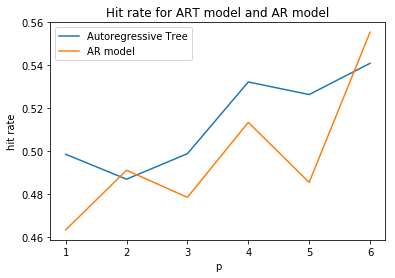

In [9]:
hit_rate_ART_list = np.mean(np.asarray(hit_rate_ART_all_samples), axis=0)
hit_rate_AR_list = np.mean(np.asarray(hit_rate_AR_all_samples), axis=0)

plt.plot(range(1, max_p), hit_rate_ART_list[:-1], label='Autoregressive Tree')
plt.plot(range(1, max_p), hit_rate_AR_list[:-1], label='AR model')
plt.title('Hit rate for ART model and AR model')
plt.xlabel('p')
plt.ylabel('hit rate')
plt.legend()
plt.show()

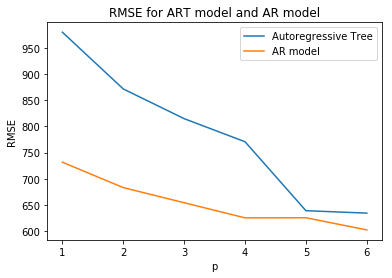

In [10]:
rmse_ART_list = np.mean(np.asarray(rmse_ART_all_samples), axis=0)
rmse_AR_list = np.mean(np.asarray(rmse_AR_all_samples), axis=0)

plt.plot(range(1, max_p), rmse_ART_list[:-1], label='Autoregressive Tree')
plt.plot(range(1, max_p), rmse_AR_list[:-1], label='AR model')
plt.title('RMSE for ART model and AR model')
plt.xlabel('p')
plt.ylabel('RMSE')
plt.legend()
plt.show()

The final output is denormalized by multiplying it by $\sigma$ and adding $\mu$.

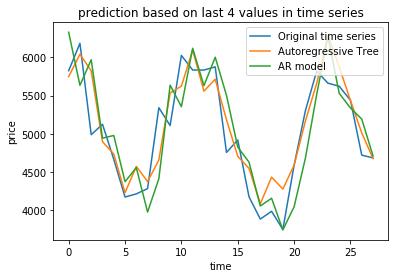

In [11]:
max_hit_rate_index = hit_rate_ART_all_samples[-1].index(max(hit_rate_ART_all_samples[-1]))
plt.plot(Ground_truth, label='Original time series')
plt.plot(valid_prediction_ART_list[max_hit_rate_index], label='Autoregressive Tree')
plt.plot(valid_prediction_AR_list[max_hit_rate_index], label='AR model')
plt.xlabel('time')
plt.ylabel('price')
i=max_hit_rate_index+1
plt.title('prediction based on last %i values in time series' %i)
plt.legend()
plt.show()

### 7.2 Model Training and Evalutaion Using Differenced Data

In [12]:
max_p=7
hit_rate_ART_all_samples = []
hit_rate_AR_all_samples = []
rmse_ART_all_samples = []
rmse_AR_all_samples = []
time_series_index_list = [350, 786, 396, 276, 614, 377, 101, 124, 62, 35]
for i in range(0,10):
    time_series_index = time_series_index_list[i]
    print('processing time series number: ',time_series_index)
    time_series_index_list.append(time_series_index)
    Ground_truth_diff, Ground_truth, valid_prediction_diff_ART_list, valid_prediction_ART_list, _ = time_series_pred(data=df3, 
                                    time_series_index=time_series_index, pred_method='ART', max_p=max_p, preprocessing_method='differencing')
    _, _, valid_prediction_diff_AR_list, valid_prediction_AR_list, _ = time_series_pred(data=df3, 
                                    time_series_index=time_series_index, pred_method='AR', max_p=max_p, preprocessing_method='differencing')

    hit_rate_ART_list = []
    hit_rate_AR_list = []
    rmse_ART_list = []
    rmse_AR_list = []
    for i in range(max_p):
        hit_rate_ART_list.append(hit_rate(Ground_truth, valid_prediction_ART_list[i]))
        hit_rate_AR_list.append(hit_rate(Ground_truth, valid_prediction_AR_list[i]))
        rmse_ART_list.append(sqrt(mean_squared_error(Ground_truth_diff, valid_prediction_diff_ART_list[i])))
        rmse_AR_list.append(sqrt(mean_squared_error(Ground_truth_diff, valid_prediction_diff_AR_list[i])))
    hit_rate_ART_all_samples.append(hit_rate_ART_list)
    hit_rate_AR_all_samples.append(hit_rate_AR_list)
    rmse_ART_all_samples.append(rmse_ART_list)
    rmse_AR_all_samples.append(rmse_AR_list)

processing time series number:  350
processing time series number:  786
processing time series number:  396
processing time series number:  276
processing time series number:  614
processing time series number:  377
processing time series number:  101
processing time series number:  124
processing time series number:  62
processing time series number:  35


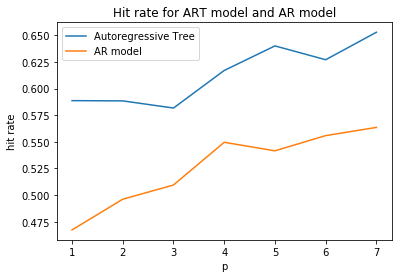

In [13]:
hit_rate_ART_list = np.mean(np.asarray(hit_rate_ART_all_samples), axis=0)
hit_rate_AR_list = np.mean(np.asarray(hit_rate_AR_all_samples), axis=0)

plt.plot(range(1, max_p+1), hit_rate_ART_list, label='Autoregressive Tree')
plt.plot(range(1, max_p+1), hit_rate_AR_list, label='AR model')
plt.xlabel('p')
plt.ylabel('hit rate')
plt.title('Hit rate for ART model and AR model')
plt.legend()
plt.show()

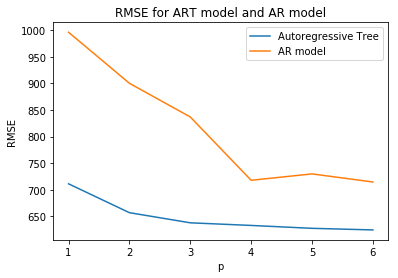

In [14]:
rmse_ART_list = np.mean(np.asarray(rmse_ART_all_samples), axis=0)
rmse_AR_list = np.mean(np.asarray(rmse_AR_all_samples), axis=0)

plt.plot(range(1, max_p), rmse_ART_list[:-1], label='Autoregressive Tree')
plt.plot(range(1, max_p), rmse_AR_list[:-1], label='AR model')
plt.xlabel('p')
plt.ylabel('RMSE')
plt.title('RMSE for ART model and AR model')
plt.legend()
plt.show()

The final output is reconstructed by cumulative sum over the predicted values. Figures are corresponding to prediction of the differenced and cumulative summed time series.

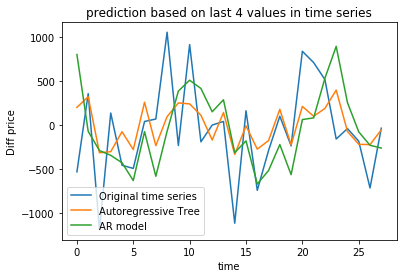

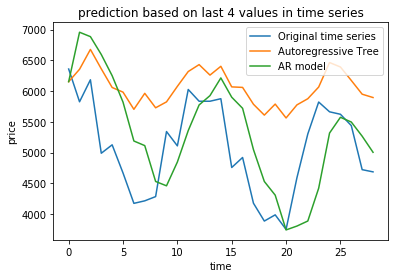

In [15]:
max_hit_rate_index = hit_rate_ART_all_samples[-1].index(max(hit_rate_ART_all_samples[-1]))

plt.plot(Ground_truth_diff, label='Original time series')
plt.plot(valid_prediction_diff_ART_list[max_hit_rate_index], label='Autoregressive Tree')
plt.plot(valid_prediction_diff_AR_list[max_hit_rate_index], label='AR model')
plt.xlabel('time')
plt.ylabel('Diff price')
i=max_hit_rate_index+1
plt.title('prediction based on last %i values in time series' %i)
plt.legend()
plt.show()
plt.plot(Ground_truth, label='Original time series')
plt.plot(valid_prediction_ART_list[max_hit_rate_index], label='Autoregressive Tree')
plt.plot(valid_prediction_AR_list[max_hit_rate_index], label='AR model')
plt.xlabel('time')
plt.ylabel('price')
i=max_hit_rate_index+1
plt.title('prediction based on last %i values in time series' %i)
plt.legend()
plt.show()

### 7.3 Conclusion
In this project, a Bayesian approach is used to learning ART models. As results shown, ART models not only generally outperform AR models, but also provide a trackable family of models for modeling non-linear time series. 
Considering both normalization and differencing approaches, ART models has higher hit rate at every order parameter $p$ in comparison with AR models. As depicted in figures Root Mean Square Error (RMSE) constantly decrease by increasing order parameter. Using differencing method, ART models reach lower RMSE in contrast with normalization method.

<a id='section8'></a>
# Bonus Section
## Stock Prediction

The utilized dataset in this work is the [New York Stock Exchange (NYSE) dataset](https://www.kaggle.com/dgawlik/nyse/data).
This dataset contains information on 140 stocks in years 2010 to 2016. We selected 26 well-known stocks for evaluating the prediction and comparison to the literature. Most of the stocks are selected inspired by works by [Y. Song](https://escholarship.org/uc/item/0cp1x8th) and [S. Atsalakis et al.](https://www.sciencedirect.com/science/article/pii/S0957417409001948). 
<br><br>The 26 selected stocks are AAPL (Apple), AIG (American International Group), AMZN (Amazon), BA (Boeing), CAT (Caterpillar), COF (Capital One), F (Ford), FDX (FedEx), GE (General Electric), GM (General Motors), GOOG (Google Alphabet Inc.), HD (The Home Depot), IBM, JNJ (Johnson \& Johnson), JPM (JPMorgan Chase \& Co.), KO (Coca-Cola), MSFT (Microsoft), NFLX (Netflix), NKE (Nike), ORCL (Oracle), PEP (PepsiCo), T (AT\&T), WMT (Walmart), XOM (ExxonMobil), and XRX (Xerox).

In [16]:
# ------ Functions:
def read_data_of_a_stock(dataset, name_of_stock):
    # taking the column of dataset having the name of stocks:
    names_of_stocks = dataset[:, 1]
    # find the indices of a specific stock:
    stock_index = np.where(names_of_stocks == name_of_stock)
    dataset_selected_stock = dataset[stock_index[0], :]
    return dataset_selected_stock

def extract_features_from_dataset(dataset):
    dataset_only_features = dataset[:, 2:]
    return dataset_only_features

# ------ Settings:
path_dataset = './prices.csv'
path_save = './saved_files/'    # GE, GOOG, ORCL and JNJ have no fundamental features, GM has not enough technical samples
# 'AAPL', 'AIG', 'AMZN', 'BA', 'CAT', 'COF', 'EBAY', 'F', 'FDX', 'GE', 'GM', 'GOOG', 'HD', 'IBM', 'JNJ', 'JPM', 'KO', \
# 'MSFT', 'NFLX', 'NKE', 'ORCL', 'PEP', 'T', 'WMT', 'XOM', 'XRX'
stocks_to_process = ['AMZN'] # 'GE', 'CAT','GM', 'IBM', 'AAPL', 'AMZN', 'NFLX', 'F'
# stocks_to_process = ['AAPL', 'AIG', 'AMZN']
number_of_stocks = len(stocks_to_process)
# print(number_of_stocks)
# ------ loading dataset:
data_df = pd.read_csv(path_dataset, delimiter=',')
data = data_df.values  # converting pandas data frame to numpy array
# ------ Preprocessing & time series forcasting:
print('Status of code: Preprocessing & time series forcasting.....')
for stock_index in range(len(stocks_to_process)):
    name_of_stock = stocks_to_process[stock_index]

    data_a_stock = read_data_of_a_stock(dataset=data, name_of_stock=name_of_stock)

    # ------ pre-processing of dataset:
    data_a_stock = extract_features_from_dataset(dataset=data_a_stock)
    total_number_of_days = data_a_stock.shape[0]
    closing = data_a_stock[:, 1].tolist()
    opening = data_a_stock[:, 0].tolist()
    lowest = data_a_stock[:, 2].tolist()
    highest = data_a_stock[:, 3].tolist()
    df_temp = pd.DataFrame([closing, opening, lowest, highest])

Status of code: Preprocessing & time series forcasting.....


In [17]:
Ground_truth_diff, Ground_truth, valid_prediction_diff_ART_list, valid_prediction_ART_list, _ = time_series_pred(data=df_temp, 
                                time_series_index=1, pred_method='ART', max_p=15, preprocessing_method='normalization')

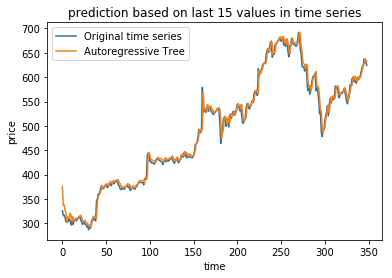

Hit rate for ART model( p: 15 )after prep 0.5100286532951289


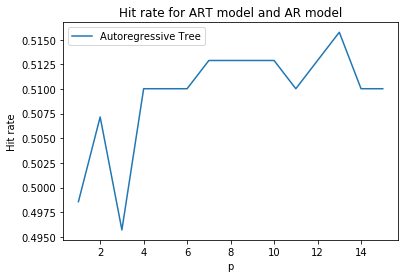

In [18]:
max_p=15
hit_rate_ART_list = []
hit_rate_AR_list = []
for i in range(max_p):
    hit_rate_ART_list.append(hit_rate(Ground_truth, valid_prediction_ART_list[i]))
    
max_hit_rate_index, max_hit_rate_value = max(enumerate(hit_rate_ART_list)) 
a = list(Ground_truth)
b = list(valid_prediction_ART_list[max_hit_rate_index])
plt.plot(a[1:], label='Original time series')
plt.plot(b[1:], label='Autoregressive Tree')
plt.xlabel('time')
plt.ylabel('price')
i=max_hit_rate_index+1
plt.title('prediction based on last %i values in time series' %i)
plt.legend()
plt.show()
print('Hit rate for ART model(','p:',max_hit_rate_index+1,')after prep', max_hit_rate_value)
plt.plot(range(1, max_p+1), hit_rate_ART_list, label='Autoregressive Tree')
plt.xlabel('p')
plt.ylabel('Hit rate')
plt.title('Hit rate for ART model and AR model')
plt.legend()
plt.show()

<a id='section9'></a>
# References
[1] C. Meek, D. M. Chickering, and D. Heckerman, “Autoregressive Tree Models for Time-Series Analysis,” in Proceedings of the 2002 SIAM International Conference on Data Mining, Philadelphia, PA: Society for Industrial and Applied Mathematics, 2002, pp. 229–244.
<br><br>[2] D. M. Chickering, C. Meek, and R. Rounthwaite, “Efficient Determination of Dynamic Split Points in a Decision Tree.”
<br><br>[3] “IIF - Time Series Data - M3-Competition.” [Online]. Available: http://forecasters.org/data/m3comp/m3comp.htm. [Accessed: 14-Aug-2018].
<br><br>[4] “New York Stock Exchange | Kaggle.” [Online]. Available: https://www.kaggle.com/dgawlik/nyse/data. [Accessed: 14-Aug-2018].
<br><br>[5] “How To Implement The Decision Tree Algorithm From Scratch In Python.” [Online]. Available: https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/. [Accessed: 14-Aug-2018].